# Project 3: Training BiLSTM POS taggers

## Due: November 10, 2023

The goal of this project is to train BILSTM models for sequence labeling, using POS tagging as an example. 

## Task definition:
POS tagging is the task of assigning a POS tag to each word token in the sentence, and it is a typical sequence labeling problem. The provided code has a skeletal implementation of a BiLSTM POS tagger, and you are asked to complete the implementation. You are asked to write two decoders for POS tagging: i) a per-token local softmax decoder that finds the best tag for each word token individually (aka "the greedy decoder"), and ii) a CRF deocoder that finds the best tag sequence among all possible tag sequences. You also need to write a corresponding negative loglikelihood loss function for each decoder.  In the case of the greedy decoder,  the negative loglikelihood loss of a sentence is the sum of the loss for individual word tokens in the sentence. When computing the same loss with the CRF model, you need to implement the forward algorithm to compute the some of all possible tag sequences. Implementing two models allows you to compare the performance of the simpler greedy model with the CRF model.

You are asked to write a training routine to train a sequence labeling model with the provided training set from the Penn TreeBank. Make sure you include code in the training routine that reports the total loss after each training iteration (epoch) over the entire training set so that you can observe the change in the total loss from iteration to iteration. If the training goes well, the loss should keep going down. If you see drastic upward and downward swings in the training loss, that's a sign that something is not working properly. Additionally you should also include code that reports the accuracy of the model on the development set every 5 or 10 iterations, so that you can observe the trend in prediction accuracy. If the improvement plateaus or starts to go down, that's a sign you should stop training.



## Data sets:
We will be using the standard train / development / test split in the Penn TreeBank for our experiments: Sections
02-21 are used for training, Section 22 is used for devevelopment, and Section 23 is used as the final test set.
You can use the development set to select the best model architecture and tune the hyperparameters. When you are done with training and tuning, you need to run your code on the test set and produce an automatically tagged version of it. The data format is very straightforward: each line of the data file contains one sentence. For the training and dev data, you are provided with the sentences with their gold POS tags. For the test set, you are only given the word tokens. The TAs will run your code on the test set to get the accuracy of your model


## Experiments
Like linear models, having the right feature representation is crucial to the performance of a neural model. In neural models, you can no longer tweak the feature templates directly. However, you can engineer a neural architecture to capture information that is analoguous to features in linear models. For instance, the BiLSTM network captures the left and right context, similar to previous and next word features in linear models. To capture affix information that might be helpful for POS tagging, you can experiment with character-level CNNs with various pooling techniques (e.g., max pooling). To capture previous tag features, you can use a transition matrix between tags.

You are asked to run a number of experiments and report results on the provided development set in this assignment.

1. Experiment with using pre-trained word embeddings such as GLOVE (https://nlp.stanford.edu/projects/glove/) or fastText (https://fasttext.cc/docs/en/english-vectors.html) with the local softmax decoder. These embeddings come with different dimensions, and start with a smaller dimension to make sure that your computing environment has sufficient memory for it and your model can train sufficiently fast. You are advised to "freeze" the word embeddings and do not update them during your training process. Compare the results from using the best pre-training embeddings and using random initialized embeddings to see if there is any difference in performance.

2. Experiment with using character CNNs with the local softmax decoder. Intuitively affixes or other parts of a word can be useful information. Typically this information is captured with character-level CNNs in neural models. Add a character-level CNN, and concatenate the output of the CNN with word embeddings, and see if this improves the performance of your BiLSTM model. Compare the results of using vs not using character CNNs.

3. In the final experiment, you are asked to compare the results for the local softmax decoder with a BiLSTM-CRF model. Training a BiLSTM-CRF model is expensive, so use the first 10,000 sentences to train the CRF model instead of the entire training set. For apple-to-apple comparisions, also train your local greedy softmax model with the same training set so that you can observe which model yields superior performance.

## Some implementation tips:

1. To take advantage of the GPU accelerator, you need to move all Pytorch tensors to GPU using to(device) or cuda().
2. A common first problem is that you'll use up all memory quickly, leading to an "out of memory" error. It is important to realize that Pytorch keep a computation history to compute the gradient. For instance, if you add up the losses for individual sentences, you may keep accumulating history and use up the memory. So instead of doing something like 'total_loss += sent_loss", do "total_loss += float(sent_loss)" to strip off history.  Also delete variables you no longer need to free up memory.
4. Dealing with unknown words: add UNK to the training vocabulary so that if there is an out-of-vocabulary (OOV) word in the development set, you can map it to UNK so that it still gets labeled.
5. If the loss (negative loglikelihood) swings up and down, you may need to adjust the learning rate (or choose a different optimizer). We suggest that you use the Adam optimizer as it is adaptive and you don't need to manually set the learning rate. 
6. In a typical deep learning model, there are many hyper-parameters that need to be manually set (learning rate /choice of optimizer, embedding and hidden dimensions, kernel sizes (CNN), number of training iterations, etc., ). This leads to many different combinations of hyper-parameters and it is hard to do an exhaustive search to find the best combination. One common technique for searching the best set of parameters is *grid search*, which allows you to specify plausible values for each hyper-parameter and search for hyper-parameter combinations systematically.

## Report
Write a report that a) briefly describe the structure of your code, b) present your experimental settings and
results, and c) any insights that you have learned from your experiments. Your report should be no longer than 5
pages.

## Project evaluation criteria

Your project will be evaluated by the correctness and thoroughness of your implementation (performing all required experiments), the performance of your best model, which usually reflects the correctness and thoroughness of your model as well as the proper selection of hyper-parameters. Your project will also be evaluated against creativity (e.g., surprising model components that lead to consistent improvement in performance), and clarity of your report. 




##### NOTE
1. regular `.py` files and the jupyter notebook are organized slightly differently, although the underlying logic is the same
2. for PA2, we will assume `batch_size` == 1
3. you can change any part of the code below
4. you are asked to submit your model's predictions on test dataset
    * the format of the export should resemble `.tagged` data
    * you will receive test accuracy as part of your feedback

## 1. Setup

In [1]:
import os
import re
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import GloVe
from torch.nn import functional as F
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [2]:
SEED = 1334
DEVICE_ID = 0
os.environ["CUDA_VISIBLE_DEVICES"] = f"{DEVICE_ID}"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
device 

device(type='cpu')

## 2. Data Loading

In [3]:
def read_in_gold_data(filename):
    """Read in the labeled gold data into a list"""
    with open(filename) as f:
        for line in f:
            tuples = [tup.split('_') for tup in line.split()]
            tokens = [tup[0] for tup in tuples]
            tags = [tup[1] for tup in tuples]
            yield (tokens, tags)
        
def read_in_plain_data(filename):
    """Read in plain text data for sequence labeling, assuming a one-sentence-per-line format"""
    with open(filename) as f:
        lines = f.readlines()
        lines = [line.split() for line in lines]
    return lines

#### Load in datasets

In [4]:
training_data = list(read_in_gold_data(r"../data/train/ptb_02-21.tagged"))
dev_data = list(read_in_gold_data(r"../data/dev/ptb_22.tagged"))
test_data = read_in_plain_data(r"../data/test/ptb_23.snt")

## 3. Vocab

#### Self-defined Vocab

In [5]:
'''
    Construct a self-defined vocabulary
'''
src_itos, char_itos, tgt_itos = set(), set(), set()

for each in training_data:
    sent_src = each[0]
    sent_char = [char for word in sent_src for char in word]
    sent_tgt = each[1]
    
    char_itos.update(sent_char)
    src_itos.update(sent_src)
    tgt_itos.update(sent_tgt)
    
'''
    Insert extra tokens into vocabularies
'''
src_itos, char_itos, tgt_itos = sorted(src_itos), sorted(char_itos), sorted(tgt_itos)
UNK = '<unk>'
PAD = '<pad>'
BOS = '<bos>' # CRF
EOS = '<eos>' # CRF

'''
    Reset the index
'''
src_itos = [UNK] + src_itos
src_itos = [PAD] + src_itos
src_stoi = {word: i for i, word in enumerate(src_itos)}
src_vocab = (src_itos, src_stoi)

char_itos = [UNK] + char_itos
char_itos = [PAD] + char_itos
char_stoi = {word: i for i, word in enumerate(char_itos)}
char_vocab = (char_itos, char_stoi)

tgt_itos = [PAD, BOS, EOS] + tgt_itos
tgt_stoi = {word: i for i, word in enumerate(tgt_itos)}
tgt_vocab = (tgt_itos, tgt_stoi)

'''
    print out the top elements
'''
print("tgt:", list(tgt_stoi.items())[:5], " tgt length:", len(tgt_itos), " tgt pad_idx:", tgt_stoi[PAD])
print("char:", list(char_stoi.items())[:5], " char length:", len(char_itos)," char pad_idx:", char_stoi[PAD])
print("src:", list(src_stoi.items())[:5], " src length:", len(src_stoi), " src pad_idx:", src_stoi[PAD])

tgt: [('<pad>', 0), ('<bos>', 1), ('<eos>', 2), ('#', 3), ('$', 4)]  tgt length: 48  tgt pad_idx: 0
char: [('<pad>', 0), ('<unk>', 1), ('!', 2), ('#', 3), ('$', 4)]  char length: 82  char pad_idx: 0
src: [('<pad>', 0), ('<unk>', 1), ('!', 2), ('#', 3), ('$', 4)]  src length: 44391  src pad_idx: 0


#### GloVe Vocab

In [6]:
def get_glove_vocabs(embedding_module):
    glove_vocab = embedding_module.stoi
    glove_vocab.update({'<unk>': embedding_module.vectors.shape[0]})
    pretrained_embeddings = embedding_module.vectors
    pretrained_embeddings = torch.cat((pretrained_embeddings, torch.rand(1,pretrained_embeddings.shape[1])))
    
    glove_vocab.update({'<pad>': embedding_module.vectors.shape[0]+1})
    pretrained_embeddings = torch.cat((pretrained_embeddings, torch.zeros(1,pretrained_embeddings.shape[1])))

    return glove_vocab, pretrained_embeddings

embedding_glove300 = GloVe(name="6B", dim=300)
glove_vocab, pretrained_embeddings = get_glove_vocabs(embedding_glove300)
glove_itos = list(glove_vocab.keys())

'''
    print out the last 5 elements
'''
print("glove:", glove_itos[-5:], " glove length:", len(glove_itos), " glove pad_idx:", glove_vocab[PAD])

glove: ['rolonda', 'zsombor', 'sandberger', '<unk>', '<pad>']  glove length: 400002  glove pad_idx: 400001


## 4. Data Iterator
* since `batch_size` is 1, we don't need to worry about padding or truncating
* and we will simply use a function to vectorize everything once and iterate one-by-one manually

#### Define two vectorized function

In [7]:
'''
    For Random embedding
'''
def convert_seq(seq, vocab, is_target=False):
    if type(seq) is str:
        seq = seq.split()
    out_seq = []
    for tok in seq:
        if tok in vocab:
            out_seq.append(vocab[tok])
        else:
            if is_target:
                raise RuntimeError(f"Unknown target token: `{repr(tok)}` from vocab: {', '.join(vocab)}")
            else:
                out_seq.append(vocab[UNK])
    return out_seq

'''
    For GloVe embedding
'''
def GloVe_seq(seq, vocab, is_target = False):
    if type(seq) is str:
        seq = seq.split()
    out_seq = []
    if is_target:
        for tok in seq:
            if tok in vocab:
                out_seq.append(vocab[tok])
            else:
                if is_target:
                    raise RuntimeError(f"Unknown target token: `{repr(tok)}` from vocab: {', '.join(vocab)}")
                else:
                    out_seq.append(vocab[UNK])
    else:
        for tok in seq:
            if tok.lower() in vocab:
                out_seq.append(vocab[tok.lower()])
            else:
                if is_target:
                    raise RuntimeError(f"Unknown target token: `{repr(tok.lower())}` from vocab: {', '.join(vocab)}")
                else:
                    out_seq.append(vocab[UNK])
        
    return out_seq

#### Define two padding fucntions

In [8]:
'''
    For Random embedding
'''
def get_vector_dataset(dataset, src_stoi, tgt_stoi):
    vectors_dataset = []
    for each in dataset:
        raw, tgt = each[0], each[1]
        src = torch.tensor(convert_seq(raw, src_stoi), dtype=torch.long)
        tgt = torch.tensor(convert_seq(tgt, tgt_stoi, is_target=True), dtype=torch.long)
        vectors_dataset.append((src, raw, tgt))
    return vectors_dataset

'''
    For GloVe embedding
'''
def get_GloVeVector_dataset(dataset, src_stoi, tgt_stoi):
    vectors_dataset = []
    for each in dataset:
        raw, tgt = each[0], each[1]
        src = torch.tensor(GloVe_seq(raw, src_stoi), dtype=torch.long)
        tgt = torch.tensor(GloVe_seq(tgt, tgt_stoi, is_target=True), dtype=torch.long)
        vectors_dataset.append((src, raw, tgt))
    return vectors_dataset

#### Vectorize and Self-defined Vocab

In [9]:
training_vectors = get_vector_dataset(training_data, src_stoi, tgt_stoi)
dev_vectors = get_vector_dataset(dev_data, src_stoi, tgt_stoi)
test_vectors = [(torch.tensor([convert_seq(each, src_stoi)][0], dtype=torch.long), each) for each in test_data]

print("Trainning Dataset: ")
print(training_vectors[0], len(training_vectors))
print("\n")
print("Testing Dataset: ")
print(test_vectors[0], len(test_vectors))

Trainning Dataset: 
(tensor([11617, 20532, 14718,  1439, 38250, 34396, 19786, 18296, 13981,     8,
        21103,  7789,    28, 10613, 18298,    36, 19786, 16321,  7928, 18104,
        41832, 17631, 30608, 19498,  7901,    31,     8, 12815,     6,  6071,
           38,    31, 41832, 38444, 34396,  7656,    31, 35763, 22622, 12351,
         7635,    31, 43742, 33350, 21178, 42127,  7847, 10900,    39]), ['In', 'an', 'Oct.', '19', 'review', 'of', '``', 'The', 'Misanthrope', "''", 'at', 'Chicago', "'s", 'Goodman', 'Theatre', '-LRB-', '``', 'Revitalized', 'Classics', 'Take', 'the', 'Stage', 'in', 'Windy', 'City', ',', "''", 'Leisure', '&', 'Arts', '-RRB-', ',', 'the', 'role', 'of', 'Celimene', ',', 'played', 'by', 'Kim', 'Cattrall', ',', 'was', 'mistakenly', 'attributed', 'to', 'Christina', 'Haag', '.'], tensor([16, 13, 23, 12, 22, 16, 47, 13, 22,  5, 16, 23, 27, 23, 23,  7, 47, 40,
        25, 41, 13, 22, 16, 23, 23,  6,  5, 22, 11, 25,  8,  6, 13, 22, 16, 23,
         6, 40, 16, 23, 23, 

#### Vectorize and GloVe Vocab

In [10]:
train_GloVe_vectors = get_GloVeVector_dataset(training_data, glove_vocab, tgt_stoi)
dev_GloVe_vectors = get_GloVeVector_dataset(dev_data, glove_vocab, tgt_stoi)
test_GloVe_vectors = [(torch.tensor(GloVe_seq(each, glove_vocab), dtype=torch.long),each) for each in test_data]

print("Trainning Dataset with GloVe Emebedding: ")
print(train_GloVe_vectors[0], len(train_GloVe_vectors))
print("\n")
print("Testing Dataset with GloVe Emebedding:")
print(test_GloVe_vectors[0], len(test_GloVe_vectors))

Trainning Dataset with GloVe Emebedding: 
(tensor([     6,     29,   2187,    904,   1287,      3,     28,      0, 108509,
            27,     22,   1147,      9,  11719,   2496, 400000,     28,  34691,
          9344,    190,      0,    912,      6,  18082,    115,      1,     27,
         10191,   1161,   1685, 400000,      1,      0,    542,      3, 400000,
             1,    334,     21,   2017,  80049,      1,     15,  13744,   4412,
             4,  12529,  47262,      2]), ['In', 'an', 'Oct.', '19', 'review', 'of', '``', 'The', 'Misanthrope', "''", 'at', 'Chicago', "'s", 'Goodman', 'Theatre', '-LRB-', '``', 'Revitalized', 'Classics', 'Take', 'the', 'Stage', 'in', 'Windy', 'City', ',', "''", 'Leisure', '&', 'Arts', '-RRB-', ',', 'the', 'role', 'of', 'Celimene', ',', 'played', 'by', 'Kim', 'Cattrall', ',', 'was', 'mistakenly', 'attributed', 'to', 'Christina', 'Haag', '.'], tensor([16, 13, 23, 12, 22, 16, 47, 13, 22,  5, 16, 23, 27, 23, 23,  7, 47, 40,
        25, 41, 13, 22, 16, 2

#### Exam the length distribution for each dataset

In [11]:
lens = np.array([len(x[0]) for x in training_vectors])
np.min(lens), np.mean(lens), np.max(lens)

(1, 23.850873669411527, 141)

In [12]:
lens = np.array([len(x[0]) for x in dev_vectors])
np.min(lens), np.mean(lens), np.max(lens)

(1, 23.598235294117647, 118)

In [13]:
lens = np.array([len(x[0]) for x in test_vectors])
np.min(lens), np.mean(lens), np.max(lens)

(1, 23.461920529801326, 67)

#### Exam the maximum length of character in each dataset

In [14]:
max_list = max([max([len(word) for word in sent[0]]) for sent in training_data])
max_list

54

In [15]:
max_list = max([max([len(word) for word in sent[0]]) for sent in dev_data])
max_list

22

In [16]:
max_list = max([max([len(word) for word in sent]) for sent in test_data])
max_list

29

#### Batchify and padding each dataset by using CustomBucketSampler and Dataloader

In [17]:
buckets_train = list(range(5, 80, 5))
buckets_GloVe = list(range(5, 80, 5))

In [18]:
def batchify(iterable, n):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
   
'''
    assign sentences with similar length to the same bucket
'''
class CustomBucketSampler:
    def __init__(self, dataset, buckets, batch_size):
        self.dataset = dataset
        self.buckets = buckets
        self.num_buckets = len(buckets) + 1
        self.batch_size = batch_size
    
    def __len__(self):
        return len(self.dataset)
    
    def __iter__(self):
        idx_lens = []
        for i, x in enumerate(self.dataset):
            idx_lens.append((i, len(x[0]) ))

        idx_lens = sorted(idx_lens, key=lambda x:x[1])
        buckets = [[] for _ in range(self.num_buckets)]
        
        # 4. assign data to appropriate buckets
        for i, l in idx_lens:
            for j, bucket_limit in enumerate(self.buckets):
                if l <= bucket_limit: # if length falls within a certain boundary
                    buckets[j].append(i)
                    break
            # for data whose length is greater than the max boundary (9), assign to last bucket
            if l > bucket_limit: # `bucket_limit` guaranteed to be 9
                buckets[-1].append(i)
               
        # make sure the numbers match up
        assert sum([len(x) for x in buckets]) == len(self.dataset)
        
        # 5. create batches in each bucket while shuffling
        batches = []
        for bucket in buckets: 
            random.shuffle(bucket)
            for batch in batchify(bucket, self.batch_size):
                if len(batch) == 60:
                    batches.append(batch)
    
        # 6. shuffle batches and finally yield
        random.shuffle(batches)
        for batch in batches:
            yield batch
        
'''
    control how to batchify data + what to return in each iteration
'''
def collate_fn(batch):
    data, raw, labels = zip(*batch)
    lens = [len(x) for x in data]
    data = pad_sequence(data, batch_first=True, padding_value=src_stoi[PAD]) # setting `batch_first` to True
    labels = pad_sequence(labels, batch_first=True, padding_value=tgt_stoi[PAD])
    return data, labels, raw, torch.tensor(lens)

def collate_fnGlove(batch):
    data, raw, labels = zip(*batch)
    lens = [len(x) for x in data]
    data = pad_sequence(data, batch_first=True, padding_value=glove_vocab[PAD])
    labels = pad_sequence(labels, batch_first=True, padding_value=tgt_stoi[PAD])
    return data, labels, raw, torch.tensor(lens)

In [19]:
batchSize = 60
train_sampler = CustomBucketSampler(training_data, buckets_train, batch_size=batchSize)
dev_sampler = CustomBucketSampler(dev_data, buckets_GloVe, batch_size=batchSize)

train_dl = DataLoader(training_vectors, collate_fn=collate_fn, batch_sampler=train_sampler)
dev_dl = DataLoader(dev_vectors, collate_fn=collate_fn, batch_sampler=dev_sampler)

train_glove_dl = DataLoader(train_GloVe_vectors, collate_fn=collate_fnGlove, batch_sampler=train_sampler)
dev_glove_dl = DataLoader(dev_GloVe_vectors, collate_fn=collate_fnGlove, batch_sampler=dev_sampler)

#### Process test dataset by using dataloader

In [20]:
def collate_fnTest(batch):
    data, raw = zip(*batch)
    lens = [len(x) for x in data]
    data = pad_sequence(data, batch_first=True, padding_value=glove_vocab[PAD])
    return data, raw, torch.tensor(lens)

In [21]:
test_glove_dl = DataLoader(test_GloVe_vectors, batch_size=len(test_GloVe_vectors),shuffle=False, collate_fn=collate_fnTest)

## 5. Hyperparameters

### Hyperparameters
customize hyperparamater values here
* for PA2, we will assume `batch_size` == 1
* default values below are arbitrary and should be modified during experiments
* feel free to add your own

In [22]:
# Hyperparameters
NUM_EPOCHS = 5
LEARNING_RATE = 0.002
EMBED_DIM = 50
HIDDEN_DIM = 50
NUM_LAYERS = 1
BIDIRECTIONAL = True
DROPOUT = 0.2

## 6. Training and Evaluation Functions

In [23]:
def train(model, dl_dataset, num_epoches, pad_idx):
    optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
    criterion = criterion.to(device)
    
    for i in range(num_epoches):
        epoch_loss = 0
        epoch_acc = 0
        num_batch = 0

        model.train()
        for src, tgt, char, batch_lens in dl_dataset:
            num_batch += 1
            model.zero_grad()

            loss, predictions, tags = model.loss_compute(src, tgt, criterion)
            loss.backward()
            optimizer.step()

            score, pred_seq = model(predictions, tags, len(tgt_itos)) 
            epoch_loss += loss.item()
            epoch_acc += score.item()
        
        print("Training Epoch # {} Loss: {:.2f} Acc: {:.2f}".format(i+1, epoch_loss, epoch_acc/num_batch))
        yield epoch_loss, epoch_acc

In [24]:
def evaluate(model, dl_dataset, tag_pad_idx):
    criterion = nn.CrossEntropyLoss(ignore_index = tag_pad_idx)
    criterion = criterion.to(device)
    
    epoch_loss = 0
    epoch_acc = 0
    num_batch = 0
    model.eval()
    
    with torch.no_grad():
        for src, tgt, char, batch_lens in dl_dataset:
            num_batch += 1

            loss, predictions, tags = model.loss_compute(src, tgt, criterion)
            max_preds = predictions.argmax(dim = 1, keepdim = True)
            non_pad_elements = (tags != tag_pad_idx).nonzero()
            pred_seq = max_preds[non_pad_elements].squeeze(1)
            correct = max_preds[non_pad_elements].squeeze(1).eq(tags[non_pad_elements])
            acc = correct.sum() / tags[non_pad_elements].shape[0]

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    print("Development Dataset Loss: {:.2f} Acc: {:.2f}".format(epoch_loss, epoch_acc/num_batch))

## 7. Model Definition + Experiments
you are advised to first implement LSTM with greedy decoder
* then move on to LSTM-CRF with viterbi decoder

### TODOs:
1. augment LSTM encoder with functions for:
    1. greedy decoding
    2. negative log likelihood
2. implement LSTM-CRF with viterbi decoder

## Experiment 1

### BiLSTM Model - Random Embedding and GloVe embedding

In [25]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, output_dim, device, src_pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, EMBED_DIM, padding_idx = src_pad_idx)
        self.dropout = nn.Dropout(DROPOUT)
        self.lstm = nn.LSTM(EMBED_DIM, HIDDEN_DIM, num_layers=NUM_LAYERS, batch_first = True, bidirectional=BIDIRECTIONAL)
        self.linear = nn.Linear(HIDDEN_DIM*2 if BIDIRECTIONAL else HIDDEN_DIM, output_dim)
        self.device = device
        
    def init_hidden(self, batchSize):
        direction_multiplier = 2 if BIDIRECTIONAL else 1
        return (torch.randn(direction_multiplier * NUM_LAYERS, batchSize, HIDDEN_DIM, device=self.device), # h0
                torch.randn(direction_multiplier * NUM_LAYERS, batchSize, HIDDEN_DIM, device=self.device)) # c0
        
    def forward(self, x):
        self.hidden = self.init_hidden(x.shape[0]) #[sentLen, 2, HIDDEN_DIM]
        embed = self.dropout(self.embedding(x)) #[batchSize, sentLen, EMBED_DIM]
        outputs, (hidden, cell) = self.lstm(embed, self.hidden) #[batchSize, sentLen, EMBED_DIM]
        outputs = self.linear(outputs)
        return outputs

class  BiLSTM_greedy(nn.Module):
    def __init__(self, input_dim, output_dim, device, src_pad_idx):
        super().__init__()
        self.lstm = BiLSTM(input_dim, output_dim, device, src_pad_idx)

    def loss_compute(self, src, tgt, criterion):
        lstm_output = self.lstm(src)
        predictions = lstm_output.view(-1, lstm_output.shape[-1])
        tags = tgt.view(-1)
        loss = criterion(predictions, tags)  
        return loss, predictions, tags
        
    def forward(self, preds, y, tag_pad_idx):

        max_preds = preds.argmax(dim = 1, keepdim = True)
        non_pad_elements = (y != tag_pad_idx).nonzero()
        correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
        pred_seq = max_preds[non_pad_elements].squeeze(1)
        score = correct.sum() / y[non_pad_elements].shape[0]
        
        return score, pred_seq.view(-1)

In [26]:
class BiLSTM_Glove(nn.Module):
    def __init__(self, GloVe_embed_dim, output_num, device, GloVe_vectors):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(GloVe_vectors, freeze = True)
        self.lstm = nn.LSTM(GloVe_embed_dim, HIDDEN_DIM, num_layers=NUM_LAYERS, batch_first = True, bidirectional=BIDIRECTIONAL)
        self.linear = nn.Linear(HIDDEN_DIM*2 if BIDIRECTIONAL else HIDDEN_DIM, output_dim)
        self.dropout = nn.Dropout(DROPOUT)
        self.device = device
        
    def init_hidden(self, batchSize):
        direction_multiplier = 2 if BIDIRECTIONAL else 1
        return (torch.randn(direction_multiplier * NUM_LAYERS, batchSize, HIDDEN_DIM, device=self.device), # h0
                torch.randn(direction_multiplier * NUM_LAYERS, batchSize, HIDDEN_DIM, device=self.device)) # c0
        
    def forward(self, x):
        self.hidden = self.init_hidden(x.shape[0]) #[2, sentLen, HIDDEN_DIM]
        word_embed = self.embedding(x)
        embed = self.dropout(word_embed) #[batchSize, sentLen, EMBED_DIM]        
        outputs, (hidden, cell) = self.lstm(embed, self.hidden) #[batchSize, sentLen, EMBED_DIM]
        outputs = self.linear(outputs)
        
        return outputs

class  BiLSTM_Glove_greedy(nn.Module):
    def __init__(self, GloVe_embed_dim, output_num, device, pretrained_embeddings):
        super().__init__()
        self.lstm = BiLSTM_Glove(GloVe_embed_dim, output_num, device, pretrained_embeddings)

    def loss_compute(self, src, tgt, criterion):
        lstm_output = self.lstm(src)
        predictions = lstm_output.view(-1, lstm_output.shape[-1])
        tags = tgt.view(-1)
        loss = criterion(predictions, tags)  
        return loss, predictions, tags
        
    def forward(self, preds, y, tag_pad_idx):

        max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
        non_pad_elements = (y != tag_pad_idx).nonzero()
        correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
        pred_seq = max_preds[non_pad_elements].squeeze(1)
        score = correct.sum() / y[non_pad_elements].shape[0]
        
        return score, pred_seq.view(-1)

#### LSTM with Random Embedding

In [27]:
input_dim = len(src_itos)
output_dim = len(tgt_itos)

BiLSTMacc = []
BiLSTMloss = []

model = BiLSTM_greedy(input_dim, output_dim, device, src_stoi[PAD]).to(device)
for loss, acc in train(model, train_dl, NUM_EPOCHS, tgt_stoi[PAD]):
    BiLSTMloss.append(loss)
    BiLSTMacc.append(acc)

Training Epoch # 1 Loss: 711.71 Acc: 0.64
Training Epoch # 2 Loss: 273.62 Acc: 0.80
Training Epoch # 3 Loss: 189.84 Acc: 0.83
Training Epoch # 4 Loss: 147.80 Acc: 0.85
Training Epoch # 5 Loss: 122.51 Acc: 0.86


In [28]:
evaluate(model, dev_dl, tgt_stoi[PAD])

Development Dataset Loss: 4.03 Acc: 0.95


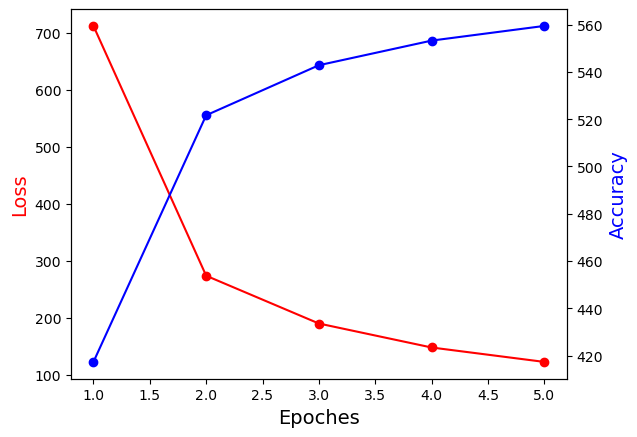

In [29]:
loss = BiLSTMloss
acc = BiLSTMacc

fig,ax = plt.subplots()
ax.plot([1,2,3,4,5], loss, color="red", marker="o")
ax.set_xlabel("Epoches",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot([1,2,3,4,5], acc,color="blue",marker="o")
ax2.set_ylabel("Accuracy",color="blue",fontsize=14)
plt.show()

#### LSTM with GloVe Embedding

In [30]:
GloVe_embed_dim = embedding_glove300.dim
output_num = len(tgt_itos)

model_Glove = BiLSTM_Glove_greedy(GloVe_embed_dim, output_num, device, pretrained_embeddings).to(device)

BiLSTM_GloVe_loss = []
BiLSTM_GloVe_acc = []

for loss, acc in train(model_Glove, train_glove_dl, NUM_EPOCHS, tgt_stoi[PAD]):
    BiLSTM_GloVe_loss.append(loss)
    BiLSTM_GloVe_acc.append(acc)

Training Epoch # 1 Loss: 449.54 Acc: 0.74
Training Epoch # 2 Loss: 169.83 Acc: 0.84
Training Epoch # 3 Loss: 134.80 Acc: 0.85
Training Epoch # 4 Loss: 119.15 Acc: 0.86
Training Epoch # 5 Loss: 109.55 Acc: 0.86


In [31]:
pred_dev_GloVe = evaluate(model_Glove, dev_glove_dl, tgt_stoi[PAD])

Development Dataset Loss: 3.52 Acc: 0.95


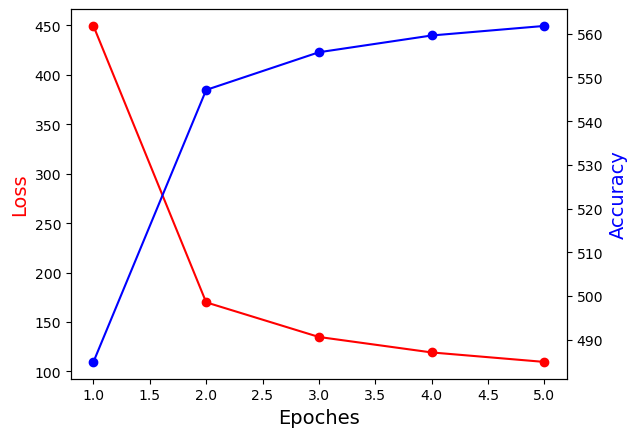

In [32]:
loss = BiLSTM_GloVe_loss
acc = BiLSTM_GloVe_acc

fig,ax = plt.subplots()
ax.plot([1,2,3,4,5], loss, color="red", marker="o")
ax.set_xlabel("Epoches",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot([1,2,3,4,5], acc,color="blue",marker="o")
ax2.set_ylabel("Accuracy",color="blue",fontsize=14)
plt.show()

#### Experiment 2

In [33]:
class CharEmbeddings(nn.Module):
    def __init__(self, char_input, char_embed_dim, char_pad_idx):
        super().__init__()
        self.embeddings = nn.Embedding(char_input, char_embed_dim, padding_idx=char_pad_idx)

    def forward(self, x, raw, char_length, char_max_length:int = 20):
        batchSize, sentLen = x.shape #[batchSize, sentLen]
        input_matrix = torch.zeros(batchSize, sentLen, char_max_length, dtype=torch.long)
        
        for i in range(batchSize):
            for j in range(char_length[i]):
                for k, char in enumerate(raw[i][j][:char_max_length]):
                    if char in char_stoi:
                        input_matrix[i,j,k] = char_stoi[char]
                    else:
                        input_matrix[i,j,k] = char_stoi[UNK]
        char_embed = self.embeddings(input_matrix)
        
        return char_embed.permute(0, 1, 3, 2) # [batchSize, sentLen, char_embed_dim, char_max_length]

In [34]:
class CharCNN(nn.Module):
    def __init__(self, char_input, char_embed_dim, char_pad_idx, GloVe_embed_dim:int = 180, kernel_size:int = 3):
        super().__init__()
        self.embeddings = CharEmbeddings(char_input, char_embed_dim, char_pad_idx)
        self.conv1d = nn.Conv1d(char_embed_dim, GloVe_embed_dim, kernel_size)

    def forward(self, x, raw, char_length): # batchSize x sentLen x char_embeddings_dim x char_max_length
        
        char_embed = self.embeddings(x, raw, char_length)
        batchSize, sentLen, char_embed_dim, char_max_length = char_embed.shape

        max_pooling_out = torch.zeros(batchSize, sentLen, GloVe_embed_dim)
        for k in range(batchSize):
            conv = F.relu(self.conv1d(char_embed[k]))
            conv = F.max_pool1d(conv, conv.shape[-1])
            conv = torch.squeeze(conv, -1)
            max_pooling_out[k] = conv
        return max_pooling_out # [batchSize, sentLen, embed_dim]

In [35]:
class BiLSTM_CNN(nn.Module):
    def __init__(self, GloVe_embed_dim, char_input, char_embed_dim, output_num, device, char_pad_idx, GloVe_vectors):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(GloVe_vectors, freeze = True)
        self.charEmbedding = CharCNN(char_input, char_embed_dim, char_pad_idx, GloVe_embed_dim)
        
        self.lstm = nn.LSTM(GloVe_embed_dim, HIDDEN_DIM, num_layers=NUM_LAYERS, batch_first = True, bidirectional=BIDIRECTIONAL)
        self.linear = nn.Linear(HIDDEN_DIM*2 if BIDIRECTIONAL else HIDDEN_DIM, output_num)
        self.dropout = nn.Dropout(DROPOUT)
        self.device = device
        
    def init_hidden(self, batchSize):
        direction_multiplier = 2 if BIDIRECTIONAL else 1
        return (torch.randn(direction_multiplier * NUM_LAYERS, batchSize, HIDDEN_DIM, device=self.device), # h0
                torch.randn(direction_multiplier * NUM_LAYERS, batchSize, HIDDEN_DIM, device=self.device)) # c0
        
    def forward(self, x, raw, char_length):
        char_embed = self.charEmbedding(x, raw, char_length)
        word_embed = self.embedding(x)
        embed = char_embed + word_embed
        
        embed = self.dropout(embed) #[batchSize, sentLen, EMBED_DIM]      
        self.hidden = self.init_hidden(embed.shape[0]) #[2, sentLen, HIDDEN_DIM]
        outputs, (hidden, cell) = self.lstm(embed, self.hidden) #[batchSize, sentLen, EMBED_DIM]
        outputs = self.linear(outputs)
        return outputs

class  BiLSTM_CNN_greedy(nn.Module):
    def __init__(self, GloVe_embed_dim, char_input_dim, char_embed_dim, output_num, device, char_pad_idx, pretrained_embeddings):
        super().__init__()
        self.lstm = BiLSTM_CNN(GloVe_embed_dim, char_input_dim, char_embed_dim, output_num, device, char_pad_idx, pretrained_embeddings)

    def loss_compute(self, x, raw, char_length, tgt, criterion):
        lstm_output = self.lstm(x, raw, char_length)
        predictions = lstm_output.view(-1, lstm_output.shape[-1])
        tags = tgt.view(-1)
        loss = criterion(predictions, tags)  
        return loss, predictions, tags
        
    def forward(self, preds, y, tag_pad_idx):

        max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
        non_pad_elements = (y != tag_pad_idx).nonzero()
        correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
        pred_seq = max_preds[non_pad_elements].squeeze(1)
        score = correct.sum() / y[non_pad_elements].shape[0]
        
        return score, pred_seq.view(-1)

In [36]:
def train_CNN(model, dl_dataset, num_epoches, tag_pad_idx):
    optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index = tag_pad_idx)
    criterion = criterion.to(device)
    
    for i in range(num_epoches):
        epoch_loss = 0
        epoch_acc = 0
        num_batch = 0

        model.train()
        for src, tgt, raw, batch_lens in tqdm(dl_dataset, desc=f"[Training {i+1}/{num_epoches}]"):
            num_batch += 1
            model.zero_grad()

            loss, predictions, tags = model.loss_compute(src, raw, batch_lens, tgt, criterion)
            loss.backward()
            optimizer.step()

            score, pred_seq = model(predictions, tags, tag_pad_idx) 
            epoch_loss += loss.item()
            epoch_acc += score.item()
        
        print("Training Epoch # {} Loss: {:.2f} Acc: {:.2f}".format(i+1, epoch_loss, epoch_acc/num_batch))
        yield epoch_loss, epoch_acc/num_batch

In [37]:
def evaluate_CNN(model, dl_dataset, tag_pad_idx):
    criterion = nn.CrossEntropyLoss(ignore_index = tag_pad_idx)
    criterion = criterion.to(device)

    epoch_loss = 0
    epoch_acc = 0
    num_batch = 0
    model.eval()
    
    with torch.no_grad():
        for src, tgt, raw, batch_lens in dl_dataset:
            num_batch += 1

            loss, predictions, tags = model.loss_compute(src, raw, batch_lens, tgt, criterion)
            max_preds = predictions.argmax(dim = 1, keepdim = True)
            non_pad_elements = (tags != tag_pad_idx).nonzero()
            pred_seq = max_preds[non_pad_elements].squeeze(1)
            correct = max_preds[non_pad_elements].squeeze(1).eq(tags[non_pad_elements])
            acc = correct.sum() / tags[non_pad_elements].shape[0]
        
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    print("Development Dataset Loss: {:.2f} Acc: {:.2f}".format(epoch_loss, epoch_acc/num_batch))

In [38]:
GloVe_embed_dim = embedding_glove300.dim
char_input = len(char_stoi)
char_embed_dim = 100
output_num = len(tgt_itos)
CNN_loss = []
CNN_Acc = []
model_CNN = BiLSTM_CNN_greedy(GloVe_embed_dim, char_input, char_embed_dim, 
                              output_num, device, char_stoi[PAD], pretrained_embeddings).to(device)
for loss, acc in train_CNN(model_CNN, train_glove_dl, NUM_EPOCHS, tgt_stoi[PAD]):
    CNN_loss.append(loss)
    CNN_Acc.append(acc)

/tmp/ipykernel_99/3604256408.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for src, tgt, raw, batch_lens in tqdm(dl_dataset, desc=f"[Training {i+1}/{num_epoches}]"):


[Training 1/5]:   0%|          | 0/39832 [00:00<?, ?it/s]

Training Epoch # 1 Loss: 296.35 Acc: 0.88


[Training 2/5]:   0%|          | 0/39832 [00:00<?, ?it/s]

Training Epoch # 2 Loss: 104.04 Acc: 0.95


[Training 3/5]:   0%|          | 0/39832 [00:00<?, ?it/s]

Training Epoch # 3 Loss: 84.81 Acc: 0.96


[Training 4/5]:   0%|          | 0/39832 [00:00<?, ?it/s]

Training Epoch # 4 Loss: 76.40 Acc: 0.96


[Training 5/5]:   0%|          | 0/39832 [00:00<?, ?it/s]

Training Epoch # 5 Loss: 70.16 Acc: 0.96


In [39]:
evaluate_CNN(model_CNN, dev_glove_dl, tgt_stoi[PAD])

Development Dataset Loss: 2.32 Acc: 0.97


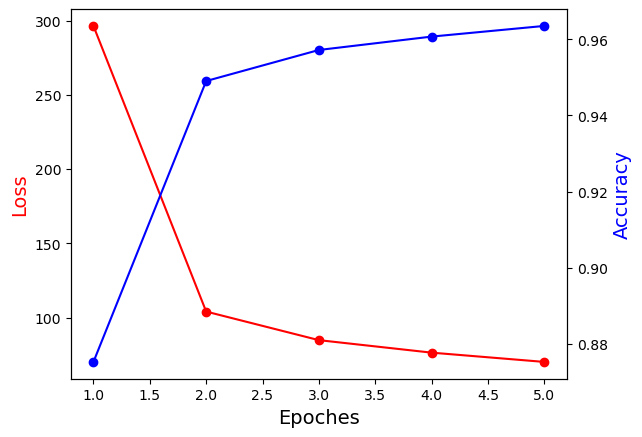

In [40]:
loss = CNN_loss
acc = CNN_Acc

fig,ax = plt.subplots()
ax.plot([1,2,3,4,5], loss, color="red", marker="o")
ax.set_xlabel("Epoches",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot([1,2,3,4,5], acc,color="blue",marker="o")
ax2.set_ylabel("Accuracy",color="blue",fontsize=14)
plt.show()

#### Experiment 3

In [41]:
class CRF(nn.Module):
    def __init__(self, tgt_vocab, device):
        super().__init__()
        self.tgt_itos, self.tgt_stoi = tgt_vocab
        self.tag_size = len(self.tgt_itos)
        self.device = device
        
        self.start_transitions = nn.Parameter(torch.empty(self.tag_size, device=device))
        self.end_transitions = nn.Parameter(torch.empty(self.tag_size, device=device))
        self.transitions = nn.Parameter(torch.empty(self.tag_size, self.tag_size, device=device))

        self.reset_parameters()
        
    def reset_parameters(self) -> None:
        nn.init.uniform_(self.start_transitions, -0.1, 0.1)
        nn.init.uniform_(self.end_transitions, -0.1, 0.1)
        nn.init.uniform_(self.transitions, -0.1, 0.1)
    
    def forward(self, feats, lens):
        emissions = feats.transpose(0, 1)
        seq_length, batch_size, _ = emissions.shape
        
        mask = torch.transpose(torch.arange(seq_length).expand(len(lens), seq_length) < lens.unsqueeze(1), 0, 1)
        score = self.start_transitions + emissions[0]
        
        for i in range(1, seq_length):
            cast_score = score.unsqueeze(2)
            cast_emission = emissions[i].unsqueeze(1)
            next_ = torch.logsumexp(cast_score + self.transitions + cast_emission, dim=1)
            score = torch.where(mask[i].unsqueeze(1), next_, score)
        score += self.end_transitions
        res = torch.logsumexp(score, dim = 1)
        return res

    def score(self, feats, tags, batch_lens):
        emissions = feats.transpose(0,1)
        tags = tags.transpose(0,1)
        seq_length, batch_size = tags.shape
        
        mask = (tags != tgt_stoi[PAD])
        tags = tags * mask

        score = self.start_transitions[tags[0]]
        score += emissions[0, torch.arange(batch_size), tags[0]]

        for i in range(1, seq_length):
            score += self.transitions[tags[i - 1], tags[i]] * mask[i]
            score += emissions[i, torch.arange(batch_size), tags[i]] * mask[i]

        seq_ends = batch_lens - 1
        last_tags = tags[seq_ends, torch.arange(batch_size)]
        score += self.end_transitions[last_tags]
        return score

    def viterbi(self, feats, batch_lens):
        # emissions: (seq_length, batch_size, num_tags)
        emissions = feats.transpose(0,1)
        seq_length, batch_size, _ = emissions.shape
        mask = torch.transpose(torch.arange(seq_length).expand(len(batch_lens), seq_length) < batch_lens.unsqueeze(1), 0, 1)
        score = self.start_transitions + emissions[0]
        history = []

        for i in range(1, seq_length):
            broadcast_score = score.unsqueeze(2)
            broadcast_emission = emissions[i].unsqueeze(1)
            next_score = broadcast_score + self.transitions + broadcast_emission
            next_score, indices = next_score.max(dim=1)
            score = torch.where(mask[i].unsqueeze(1), next_score, score)
            history.append(indices)
        
        score += self.end_transitions
        seq_ends = mask.long().sum(dim=0) - 1
        best_tags_list = []

        for idx in range(batch_size):
            
            _, best_last_tag = score[idx].max(dim=0)
            best_tags = [best_last_tag.item()]
            
            for hist in reversed(history[:seq_ends[idx]]):
                best_last_tag = hist[idx][best_tags[-1]]
                best_tags.append(best_last_tag.item())
                
            best_tags.reverse()
            best_tags_list.append(best_tags)
        return best_tags_list

class  BiLSTM_CRF(nn.Module):
    def __init__(self, GloVe_embed_dim, char_input, char_embed_dim, output_num, device, char_pad_idx, pretrained_embeddings, tgt_vocab):
        super().__init__()
        self.lstm = BiLSTM_CNN(GloVe_embed_dim, char_input, char_embed_dim, output_num, device, char_pad_idx, pretrained_embeddings)
        self.crf = CRF(tgt_vocab, device)
    
    def neg_log_likelihood(self, src, raw, tgt, batch_lens):
        feats = self.lstm(src, raw, batch_lens)
        forward_score = self.crf(feats, batch_lens)
        gold_score = self.crf.score(feats, tgt, batch_lens)
        return torch.sum(forward_score - gold_score)

    def forward(self, src, raw, batch_lens):
        feats = self.lstm(src, raw, batch_lens)
        out = self.crf.viterbi(feats, batch_lens)
        return out 

In [42]:
def train_CRF(model, dl_dataset, num_epoches):
    optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
    
    for i in range(num_epoches):
        epoch_loss = 0
        num_correct = 0
        num_batch = 0
        num_tag = 0
        epoch_acc = 0

        model.train()
        for src, tgt, raw, batch_lens in tqdm(dl_dataset, desc=f"[Training {i+1}/{num_epoches}]"):
            num_batch += 1
            model.zero_grad()

            loss = model.neg_log_likelihood(src, raw, tgt, batch_lens)
            loss.backward()
            optimizer.step()
            pred = model(src, raw, batch_lens)
            
            for i in range(src.shape[0]):
                length = batch_lens[i]
                num_correct += (torch.tensor(pred[i]) == tgt[i, :length]).sum()
                num_tag += length

            epoch_loss += loss.item()
            epoch_acc = num_correct.item()/num_tag
        
        print("Training Epoch # {} Loss: {:.2f} Acc: {:.2f}".format(i+1, epoch_loss/num_batch, epoch_acc))
        yield epoch_loss/num_batch, epoch_acc

In [43]:
def evaluate_CRF(model, dl_dataset):
    
    num_correct = 0
    num_batch = 0
    num_tag = 0
    epoch_acc = 0
    epoch_loss = 0
    
    model.eval()
    
    with torch.no_grad():
        for src, tgt, raw, batch_lens in tqdm(dl_dataset):
            num_batch += 1

            loss = model.neg_log_likelihood(src, raw, tgt, batch_lens)
            pred = model(src, raw, batch_lens)
            
            for i in range(src.shape[0]):
                length = batch_lens[i]
                num_correct += (torch.tensor(pred[i]) == tgt[i, :length]).sum()
                num_tag += length

            epoch_loss += loss.item()
            epoch_acc = num_correct.item()/num_tag
        
        print("Training Epoch # {} Loss: {:.2f} Acc: {:.2f}".format(i+1, epoch_loss/num_batch, epoch_acc))

In [44]:
GloVe_embed_dim = embedding_glove300.dim
char_input = len(char_stoi)
char_embed_dim = 100
output_num = len(tgt_itos)
CRF_loss = []
CRF_acc = []
model_crf = BiLSTM_CRF(GloVe_embed_dim, char_input, char_embed_dim, output_num, device, char_stoi[PAD], pretrained_embeddings, tgt_vocab).to(device)
for loss, acc in train_CRF(model_crf, train_glove_dl, NUM_EPOCHS):
    CRF_loss.append(loss)
    CRF_acc.append(acc)

/tmp/ipykernel_99/1367825914.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for src, tgt, raw, batch_lens in tqdm(dl_dataset, desc=f"[Training {i+1}/{num_epoches}]"):


[Training 1/5]:   0%|          | 0/39832 [00:00<?, ?it/s]

Training Epoch # 60 Loss: 575.24 Acc: 0.89


[Training 2/5]:   0%|          | 0/39832 [00:00<?, ?it/s]

Training Epoch # 60 Loss: 189.92 Acc: 0.96


[Training 3/5]:   0%|          | 0/39832 [00:00<?, ?it/s]

Training Epoch # 60 Loss: 157.25 Acc: 0.96


[Training 4/5]:   0%|          | 0/39832 [00:00<?, ?it/s]

Training Epoch # 60 Loss: 141.97 Acc: 0.97


[Training 5/5]:   0%|          | 0/39832 [00:00<?, ?it/s]

Training Epoch # 60 Loss: 131.64 Acc: 0.97


In [45]:
pred_dev_GloVeCRF = evaluate_CRF(model_crf, dev_glove_dl)

/tmp/ipykernel_99/3931114797.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for src, tgt, raw, batch_lens in tqdm(dl_dataset):


  0%|          | 0/1700 [00:00<?, ?it/s]

Training Epoch # 60 Loss: 123.14 Acc: 0.97


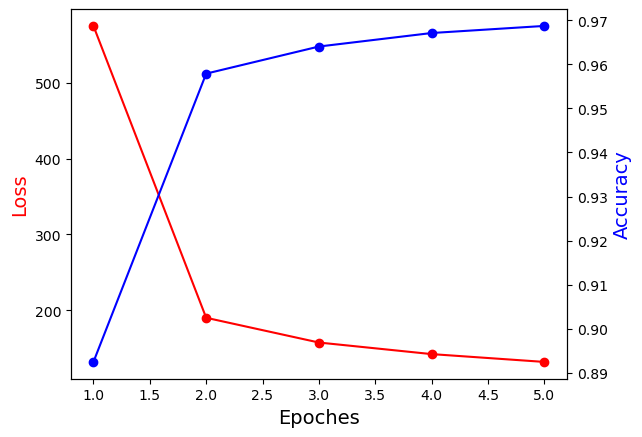

In [46]:
loss = CRF_loss
acc = CRF_acc

fig,ax = plt.subplots()
ax.plot([1,2,3,4,5], loss, color="red", marker="o")
ax.set_xlabel("Epoches",fontsize=14)
ax.set_ylabel("Loss",color="red",fontsize=14)

ax2=ax.twinx()
ax2.plot([1,2,3,4,5], acc,color="blue",marker="o")
ax2.set_ylabel("Accuracy",color="blue",fontsize=14)
plt.show()

### C. After Training

In [47]:
def get_Pred_CRF(model, dl_dataset):
    num_batch = 0
    model.eval()
    
    with torch.no_grad():
        for src, raw, batch_lens in tqdm(dl_dataset):
            num_batch += 1
            pred = model(src, raw, batch_lens)
    return pred

In [48]:
pred_test_GloVeCRF = get_Pred_CRF(model_crf, test_glove_dl)

/tmp/ipykernel_99/350087582.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for src, raw, batch_lens in tqdm(dl_dataset):


  0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
# for i, x in enumerate(pred_test_GloVeCRF):
#     line = ["_".join((test_data[i][j], tgt_itos[word])) for j, word in enumerate(x)]
#     print(" ".join(line))

In [50]:
with open('ptb_23.tagged', 'w') as f:
    for i, x in enumerate(pred_test_GloVeCRF):
        line = ["_".join((test_data[i][j], tgt_itos[word])) for j, word in enumerate(x)]
        f.write(" ".join(line))
        f.write("\n")